# Math explanation of diffusion models

## Forward diffusion process

Quote from paper:
What distinguishes diffusion models from other types of latent variable models is that the approximate posterior $q(x_{1:T} |x_0)$, called the forward process or diffusion process, is fixed to a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule β1 , . . . , βT:

$q(x_{1:T} |x_0) := \prod_{t=1}^n q(x_t|x_t−1)$ <br/>
$q(x_t|x_{t−1}) := \mathcal{N}(x_t, \sqrt{1 − β_t}x_{t−1}, β_tI)$

Let's implement the process above in Python

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import numpy as np
import src.utils

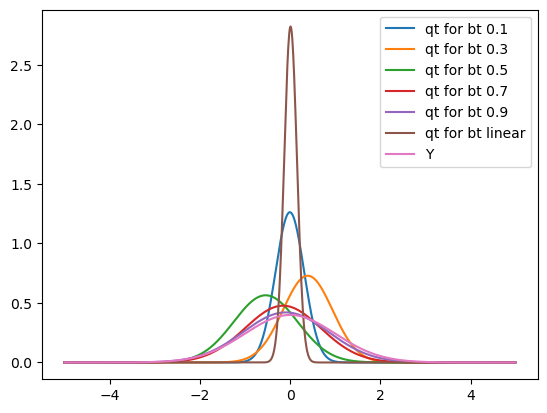

In [88]:
# Implement q function with 1 dimensional argument
# We have to fix a seed to get the same results

# Fix a seed to get the same results
utils.seed_everything(1000)

# Number of timesteps
timestep = 800

# Our interval
xs = np.arange(-5, 5, 0.01)

# Apply normal pdf to xs with 0 mean and 1 variance (Just to check graph with our graphs)
y_results = norm.pdf(xs, 0, 1)

different_schedules = [
    # constant
    np.ones(timestep) * 0.1,
    np.ones(timestep) * 0.3,
    np.ones(timestep) * 0.5,
    np.ones(timestep) * 0.7,
    np.ones(timestep) * 0.9,
    # linear change (from paper)
    np.linspace(1e-4, 0.02, timestep)
]

# set x0 some random value from -1 to 1
x0 = 3

for bt in different_schedules:

    # Set xt to zero, which will be used as x(t-1) like in sqrt(1-b) * x(t-1)
    xt = x0

    q_results = None

    # A simple loop by timestep
    for t in range(timestep):

        # Calculate the mean as in the formula
        mean = math.sqrt(1 - bt[t]) * xt

        # Calculate the variance
        variance = bt[t]

        # Q is a normal distribution, so to get the next xt, we just get random element from our distribution
        xt = np.random.normal(mean, math.sqrt(variance))
    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(xs, q_results, label=f"qt for bt {bt[0] if bt[0] == bt[-1] else 'linear'}")
plt.plot(xs, y_results, label="Y")
plt.legend()
plt.show()

$q(x_t|x_{t−1}) := \mathcal{N}(x_t, \sqrt{1 − β_t}x_{t−1}, β_tI)$

In previous code we have a line:

`xt = np.random.normal(mean, math.sqrt(variance))`

Which means we always get some random variable. If we want to make a backpropagation in the future, it's hard to do it, because we can not make deriviative $x_t$ by $x_{t-1}$.
To avoid this situation lets make reparametrization trick.

$x_t \sim q(x_t | x_{t-1}) := \mathcal{N}(x_t, \mu_{t-1}, \delta_{t-1} ^2 ) $ <br/>
$x_t = \mu_{t-1} + \delta_{t-1} * \epsilon$, where $\epsilon \sim \mathcal{N}(0, I)$

For our case we have:

$x_t = \sqrt{1 - \beta_t}x_{t-1} + \beta_t * \epsilon$, where $\epsilon \sim \mathcal{N}(0, I)$

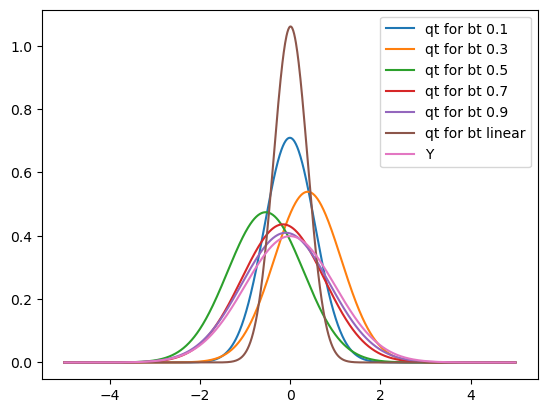

In [90]:
# Fixed seed to get the same results
utils.seed_everything(1000)

for bt in different_schedules:

    # Set xt to zero, which will be used as x(t-1) like in sqrt(1-b) * x(t-1)
    xt = x0

    q_results = None

    # A simple loop by timestep
    for t in range(timestep):

        # Calculate the mean as in the formula
        mean = math.sqrt(1 - bt[t]) * xt

        # Calculate the variance
        variance = math.sqrt(bt[t])

        # Get eps from normal distribution
        eps = np.random.normal(0, 1)
        
        # Calculate our xt
        xt = mean + variance * eps
    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(xs, q_results, label=f"qt for bt {bt[0] if bt[0] == bt[-1] else 'linear'}")
plt.plot(xs, y_results, label="Y")
plt.legend()
plt.show()

As we can see first two methods leads us to some normal distribution in the end for all beta schedules.

Right now we have a direct formula to compute $x_t$. When we are working in one dimensional, it's so easy and fast to compute $x_t$, but if we want to work in 100D, 1000D, 10000D, etc. our loop will be a big pain and have a bad performance.

Can we avoid our timestep loop? Let's go to formulas

$\alpha_t = 1 - \beta_t, \bar \alpha_t = \prod_{i=1}^t\alpha_i$ <br/>
$x_t = \sqrt{\alpha_t}x_{t-1} + \sqrt{1 - \alpha_t} * \epsilon_t = \sqrt{\alpha_t} \sqrt{\alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t * (1 - \alpha_{t-1})} * \epsilon_{t-1} + \sqrt{1 - \alpha_t} * \epsilon_t$

$\epsilon_t \sim \mathcal{N}(0, \delta_t^2 I)$ and $\epsilon_{t-1} \sim \mathcal{N}(0, \delta_{t-1}^2 I)$. So their merge will be $\mathcal{N}(0, (\delta_t^2 + \delta_{t-1}^2)I)$. Rewrite the formula above:

$x_t=\sqrt{\alpha_t * \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t * (1 - \alpha_{t-1}) + 1 - \alpha_t} * \bar{\epsilon_{t-2}} = \sqrt{\alpha_t * \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t * \alpha_{t-1}} * \bar{\epsilon_{t-2}}$ <br/>

And then we can continue this line until we reach x0: <br/>
$x_t=\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} * \bar{\epsilon}$

Lets try to implement it and compare results with previous graphs.

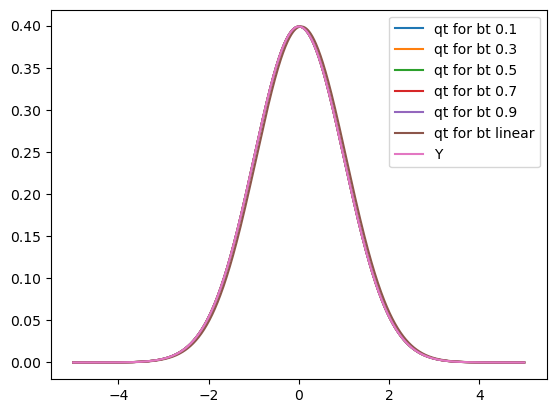

In [91]:
# Fixed seed to get the same results
utils.seed_everything(1000)

for bt in different_schedules:
    alpha_t = 1 - bt
    cumprod_alpha_t = np.cumprod(alpha_t)
    mean = math.sqrt(cumprod_alpha_t[-1]) * x0
    variance = math.sqrt(1 - cumprod_alpha_t[-1])
    eps = np.random.normal(0, 1)
    variance = variance
    xt = mean + eps * variance
    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(xs, q_results, label=f"qt for bt {bt[0] if bt[0] == bt[-1] else 'linear'}")
plt.plot(xs, y_results, label="Y")
plt.legend()
plt.show()

As we can see the last method take us closer to Normal distribution with zero mean and one variance.
So, now we have transformation of a point(point will be an image) to point from Normal distribution(image with a noise).

## Reverse diffusion process

### Problem with reverse diffusion process

What about a reverse diffusion process:
$q(x_{t-1}|x_t)$ ?

As we can see, we don't have enough data to make this transformation, but we can do something like this:
$q(x_{t-1}|x_t, x_0)$

**What doest it mean?** We try to find the distribution $x_{t-1}$, knowing distribution $x_t, x_0$.

I will provide formulas of this calculation later. But right now the question is: can we draw $q(x_{t-1}|x_t)$ from $q(x_{t-1}|x_t, x_0)$ ?

Yes, we just need some formulas from statistic theory ([very good explanation](https://stats.libretexts.org/Courses/Saint_Mary's_College_Notre_Dame/MATH_345__-_Probability_(Kuter)/1%3A_What_is_Probability)).

Let's do some magic.

$\begin{aligned}q(x_{t-1}|x_t, x_0) = \frac{q(x_{t-1}, x_t, x_0)}{q(x_t, x_0)}\end{aligned}$ (1)

$\begin{aligned}q(x_{t-1}|x_t)=\int_{x_0} q(x_{t-1}, x_0|x_t) \mathrm{d}x_0\end{aligned}$ (2)

$\begin{aligned}q(x_{t-1}, x_0| x_t) = \frac{q(x_{t-1}, x_0, x_t)}{q(x_t)} \end{aligned}$ (3)

Drawing numerator from (1) and (3) and assining them to each other, we have <br/><br/>
$\begin{aligned} q(x_{t-1}|x_t, x_0) * q(x_t, x_0) = q(x_{t-1}, x_0| x_t) * q(x_t) => q(x_{t-1}, x_0| x_t) = q(x_{t-1}|x_t, x_0) * \frac{q(x_t, x_0)}{q(x_t)} \end{aligned}$

$\begin{aligned} q(x_{t-1}, x_0| x_t) = q(x_{t-1}|x_t, x_0) * q(x_0|x_t) \end{aligned}$

And redraw formula (2):
$q(x_{t-1}|x_t)=\int q(x_{t-1}|x_t, x_0) * q(x_0|x_t) \mathrm{d}x_0$

With Bayes formula we can draw $q(x_0|x_t)$ as $\begin{aligned} q(x_t|x_0) * \frac{q(x_0)}{q(x_t)} \end{aligned}$

So to calculate $q(x_{t-1}|x_t)$ we should make integral through all x0 (our images dataset), which means a lot of computations and super slow as the result.

### Working with $q(x_{t-1}|x_t, x_0)$

First of all, we should say, that if $\beta$ is small and $q(x_t|x_{t-1})$ is Gaussian, then $q(x_{t-1}|x_t)$ is Gaussian too. A quote from paper:

"For both Gaussian and binomial diffusion, for continuous diffusion (limit of small step size β) the reversal of the diffusion process has the identical functional form as the forward process (Feller, 1949)."

I tried to read Feller original, but it was so hard to understand, so let's take this fact as true.

So if it is Gaussian, we should try to find $\mu$ and $\delta$ of this Gaussian. Lets do it.

Using Bayes' rule we have (took part of calculations from [Lil Log article](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)): <br/>
$\begin{aligned}q(x_{t-1}|x_t, x_0) = q(x_{t}|x_{t-1},x_0) * \frac{q(x_{t}|x_0)}{q(x_{t-1}|x_0)}\end{aligned}$<br/>
$\begin{aligned}\propto \exp (-\frac{1}{2} * (\frac{(x_t - \sqrt{\alpha_t}x_{t-1})^2}{\beta_t} + \frac{(x_{t-1} - \sqrt{\bar \alpha_{t-1}}x_0)^2}{1 - \bar \alpha_{t-1}} - \frac{(x_{t} - \sqrt{\bar \alpha_{t}}x_0)^2}{1 - \bar \alpha_t})) \end{aligned}$<br/>
$\begin{aligned}
&= \exp (-\frac{1}{2} (\frac{\mathbf{x}_t^2 - 2\sqrt{\alpha_t} \mathbf{x}_t \mathbf{x}_{t-1} + \alpha_t \mathbf{x}_{t-1}^2 }{\beta_t} + \frac{ {\mathbf{x}_{t-1}^2} {- 2 \sqrt{\bar{\alpha}_{t-1}} \mathbf{x}_0} {\mathbf{x}_{t-1}} + \bar{\alpha}_{t-1} \mathbf{x}_0^2}  {1-\bar{\alpha}_{t-1}} - \frac{(\mathbf{x}_t - \sqrt{\bar{\alpha}_t} \mathbf{x}_0)^2}{1-\bar{\alpha}_t} ) ) \\
&= \exp\Big( -\frac{1}{2} \big( {(\frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}})} \mathbf{x}_{t-1}^2 - (\frac{2\sqrt{\alpha_t}}{\beta_t} \mathbf{x}_t + \frac{2\sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_{t-1}} \mathbf{x}_0) \mathbf{x}_{t-1} + C(\mathbf{x}_t, \mathbf{x}_0) \big) \Big)
\end{aligned}$

Just reminder:

$\begin{aligned} N(x, \mu, \delta^2) \sim x \propto \exp (-1/2 * \frac{(x - \mu) ^ 2}{\delta^2}) \end{aligned}$

Look detally at:

$\begin{aligned}\frac{(x - \mu) ^ 2}{\delta^2} = \frac{(x^2 - 2x\mu + \mu^2)}{\delta^2} = \frac{1}{\delta^2} * x^2 - 2 * \frac{\mu}{\delta^2} * x + ... \end{aligned}$

If we have $A * x ^ 2$, then $\delta^2 = 1 / A$. Similar for $\mu: B * x => \mu = -\frac{1}{2} * \delta^2 * B $

Draw our mean and variance for $q(x_{t-1}|x_t, x_0)$

$\begin{aligned} (\frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}}) \mathbf{x}_{t-1}^2 => \delta^2 = 1/A = 1 / (\frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}}) = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_{t}} \beta_t \end{aligned}$


$\begin{aligned} -(\frac{2\sqrt{\alpha_t}}{\beta_t} \mathbf{x}_t + \frac{2\sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_{t-1}} \mathbf{x}_0) \mathbf{x}_{t-1} => \mu = -\frac{1}{2} * \delta^2 * B = \frac{\sqrt{\alpha_t}(1- \bar \alpha_{t-1})}{1 - \bar \alpha_t}x_t + \frac{\sqrt{\bar \alpha_{t-1}} * \beta_t}{1 - \bar{\alpha_{t}}}x_0 \end{aligned}$

Now $q(x_{t-1}|x_t, x_0) \sim N(x_{t-1}, \mu(x_t, x_0), \tilde \beta_tI)$. Now we have:

<a name="formula_4"></a>

$\begin{aligned} \tilde \beta_t = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_{t}} \beta_t \end{aligned}$ <span style="color: blue"> (4) </span>

<a name="formula_5"></a>

$\begin{aligned} \mu(x_t, x_0) = \frac{\sqrt{\alpha_t}(1- \bar \alpha_{t-1})}{1 - \bar \alpha_t}x_t + \frac{\sqrt{\bar \alpha_{t-1}} * \beta_t}{1 - \bar{\alpha_{t}}}x_0 \end{aligned}$ <span style="color: blue"> (5) </span>

Recall that $x_t=\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} * \bar{\epsilon}$, draw $x_0$ through $x_t$

$\begin{aligned}x_0=\frac{1}{\sqrt{\bar \alpha_t}} (x_t - \sqrt{1 - \bar \alpha_t} * \bar{\epsilon}) \end{aligned}$

Next, draw our new $\tilde \mu_t$ without $x_0$

$\begin{aligned} \tilde \mu_t = \frac{\sqrt{\alpha_t}(1- \bar \alpha_{t-1})}{1 - \bar \alpha_t}x_t + \frac{\sqrt{\bar \alpha_{t-1}} * \beta_t}{(1 - \bar{\alpha_{t}})\sqrt{\bar \alpha_t}}(x_t - \sqrt{1 - \bar \alpha_t} * \bar{\epsilon})=\frac{1}{\sqrt{\alpha_t}}x_t - \frac{1}{\sqrt{\alpha_t}} * \frac{\sqrt{1 - \bar \alpha_t}}{1 - \bar \alpha_t} * \beta_t * \bar {\epsilon} \end{aligned}$

Recall $\beta_t = 1 - \alpha_t$ we have

<a name="formula_6"></a>

$\begin{aligned} \tilde \mu_t = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \bar {\epsilon}) \end{aligned}$ <span style="color: blue"> (6) </span>

### Transition from $q(x_{t-1}|x_t)$ to $p_\theta(x_{t-1}|x_t)$

As we saw before, we can not calculate $q(x_{t-1}|x_t)$ , so we introduce a model $p_\theta(x_{t-1}|x_t)$, which approximate our q.
As we discussed earlier $q(x_{t-1}|x_t)$ is Gaussian, so $p_\theta(x_{t-1}|x_t)$ is Gaussian too. So we have:

$p_\theta(x_{t-1}|x_t) = N(x_{t-1}, \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)) \quad p(x_{0...T}) = p(x_{0:T}) = p(x_T) * \prod_{t=1}^T p_\theta(x_{t-1}|x_t)$

We have model $p_\theta(x_{t-1}|x_t)$, which describes some distribution and we have distribution $q(x_{t-1}|x_t)$ and we want to find optimal $\theta$, that $p_\theta$ will be the closest to $q$. It sounds we have to find a loss function.

To do this let's write likelihood for $p_\theta$

$p_\theta(x) = \int p_\theta(x_{0:T})\mathrm{d}x_1,...x_T$`

Our goal is to maximize it, write logarithm of likelihood:

$\begin{aligned}
\log p_\theta(x) &= \log \int p_\theta(x_{0:T})\mathrm{d}x_1,...x_T \\
&= \log \int p_\theta(x_{0:T}) * \frac{q(x_{1:T}|x_0)}{q(x_{1:T}|x_0)}\mathrm{d}x_1,...x_T \\
&= \log \int q(x_{1:T}|x_0) * \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)}\mathrm{d}x_1,...x_T \\
&= \log E_{q(x_{1:T}|x_0)} \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} \\
\end{aligned}$

Now let's write Jensen’s Inequality:
$f(E(x)) <= E(f(x))$, if $f(x)$ is a convex function and $f(E(x)) >= E(f(x))$, if $f(x)$ is a concave.

$log(x)$ is a concave, so:
$log(E(x)) >= E(log(x))$

Rewrite our formula above:

$\begin{aligned}
\log p_\theta(x) &= \log E_{q(x_{1:T}|x_0)} \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} \\
&>= E_{q(x_{1:T}|x_0)} \log [ \frac{p_\theta(x_T) * \prod_{t=1}^{T} p_\theta(x_{t-1}|x_t)}{\prod_{t=1}^{T} q(x_t|x_{t-1}) } ] \\
&= E_{q(x_{1:T}|x_0)}[ \log  \frac{p_\theta(x_T) * p_\theta(x_0|x_1) * \prod_{t=2}^{T} p_\theta(x_{t-1}|x_t)}{q(x_T|x_{T-1}) * \prod_{t=1}^{T-1} q(x_t|x_{t-1}) } ] \\
&= E_{q(x_{1:T}|x_0)}[ \log  \frac {p_\theta(x_T) * p_\theta(x_0|x_1) * \prod_{t=2}^{T} p_\theta(x_{t-1}|x_t) } { q(x_1|x_0) * \prod_{t=2}^{T} q(x_t|x_{t-1}) } ] \\
&= E_{q(x_{1:T}|x_0)}[ \log  \frac {p_\theta(x_T) * p_\theta(x_0|x_1) } { q(x_1|x_0) } +
\log \prod_{t=2}^{T} \frac { p_\theta(x_{t-1}|x_t) } { q(x_t|x_{t-1}) } ] \\
&= E_{q(x_{1:T}|x_0)}[ \log  \frac {p_\theta(x_T) * p_\theta(x_0|x_1) } { q(x_1|x_0) } +
\log \prod_{t=2}^{T} \frac { p_\theta(x_{t-1}|x_t) } { \frac { q(x_{t-1}|x_t, x_0) * \cancel { q(x_t|x_0) } } { \cancel { q(x_{t-1} | x_0) } } } ] \\
&= E_{q(x_{1:T}|x_0)}[ \log  \frac {p_\theta(x_T) * p_\theta(x_0|x_1) } { q(x_1|x_0) } +
\log  \frac {q_(x_1|x_0) } { q(x_T|x_0) } +
\log \prod_{t=2}^{T} \frac { p_\theta(x_{t-1}|x_t) } { q(x_{t-1}|x_t, x_0) } ] \\
&= E_{q(x_{1:T}|x_0)}[ \log \frac{p_\theta(x_T) * p_\theta(x_0|x_1)}{q(x_T|x_0) }] +
E_{q(x_{1:T}|x_0)}[ \log  \prod_{t=2}^{T} \frac {p_\theta(x_{t-1}|x_{t})}{q(x_{t-1}|x_{t}, x_0)} ] \\
&= E_{q(x_{1:T}|x_0)} \log p_\theta(x_0|x_1) +
E_{q(x_{1:T}|x_0)} \log \frac{p_\theta(x_T)}{q(x_T|x_{0}) } +
E_{q(x_{1:T}|x_0)}[ \sum_{t=2}^{T} \log  \frac {p_\theta(x_{t - 1}|x_{t})}{q(x_{t-1}|x_{t},x_0)} ] \\
&= E_{q(x_1|x_0)} \log p_\theta(x_0|x_1) +
E_{q(x_T|x_0)} \log \frac{p_\theta(x_T)}{q(x_T|x_0) } +
\sum_{t=2}^{T} [E_{q(x_{t-1},x_t|x_0)} \log  \frac {p_\theta(x_{t-1}|x_{t})}{q(x_{t-1}|x_{t},x_0)} ] \\
&= E_{q(x_1|x_0)} \log p_\theta(x_0|x_1) -
D_{KL} (q(x_T|x_0) || p_\theta(x_T)) -
\sum_{t=2}^{T} [E_{q(x_{t-1}|x_0)} D_{KL} (q(x_{t-1}|x_t, x_0) || p_\theta(x_{t-1}|x_t)) ]
\end{aligned}$

$\log p_\theta(x) >= E_{q(x_1|x_0)} \log p_\theta(x_0|x_1) -
D_{KL} (q(x_T|x_0) || p_\theta(x_T)) -
\sum_{t=2}^{T} [E_{q(x_{t-1}|x_0)} D_{KL} (q(x_{t-1}|x_t, x_0) || p_\theta(x_{t-1}|x_t)) ]$ <span style="color: blue"> (7) </span>

Name of the formula above is Evidence Lower Bound (ELBO). And special thanks to Calvin Luo with his great [article](https://calvinyluo.com/2022/08/26/diffusion-tutorial.html#mjx-eqn%3Aeq%3A79) with explanations of math.

In formula above first statement E(q) and second state don't depend on t, so we can skip them and work only with the last statement.
Our goal is to maximize log likelihood, so from [formula 6](#formula_6) we should to minimize $\sum_{t=2}^{T} [E_{q(x_{t-1}|x_0)} D_{KL} (q(x_{t-1}|x_t, x_0) || p_\theta(x_{t-1}|x_t)) ]$

$D_{KL}$ is always positive, our goal is to minimize it.

It seems we found our loss function. Couple words about Kullback–Leibler divergence.

KL Divergence or $D_{KL}(P||Q)$ shows how probability distribution P differs from another probability distribution Q. If P and Q equal, then $D_{KL} = 0$

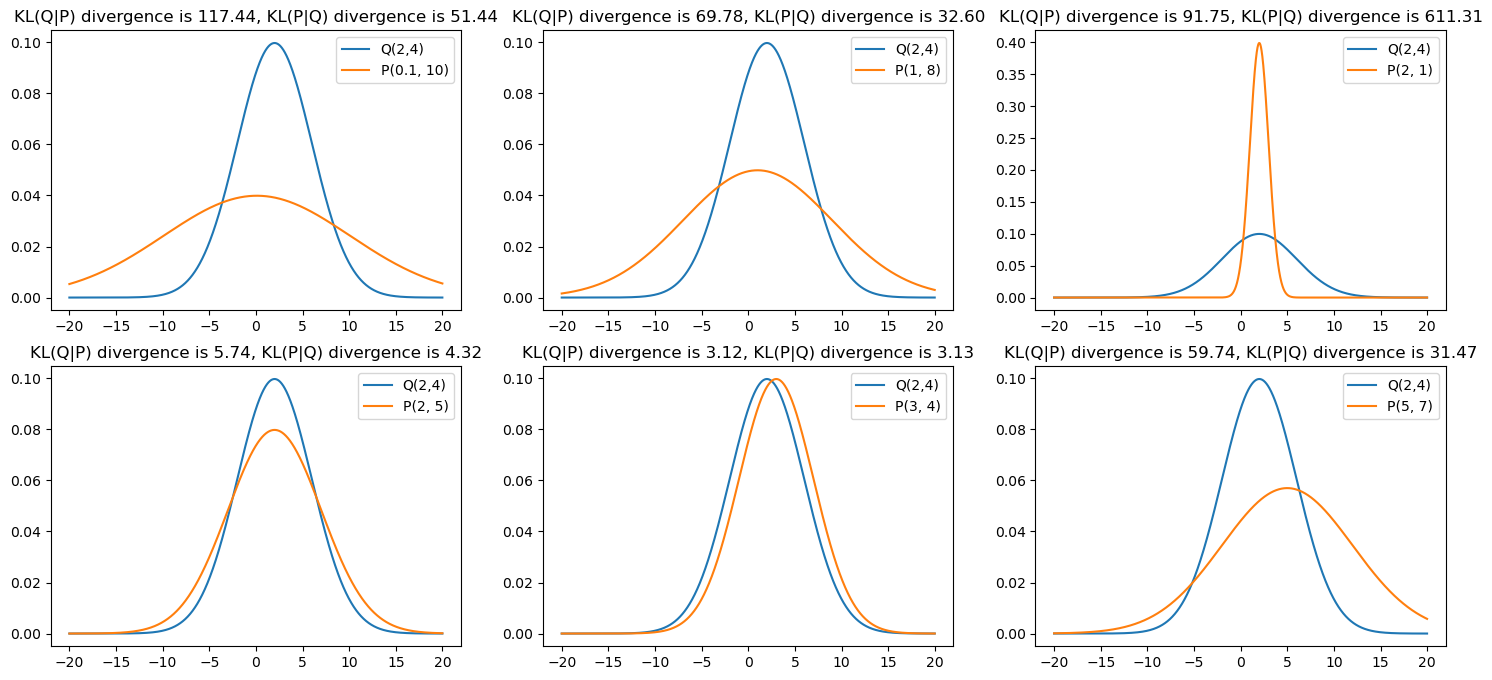

In [25]:
# Show KL divergence on sample with two Gaussians

# Fix a seed to get the same results
utils.seed_everything(1000)

# Our interval
xs = np.arange(-20, 20, 0.01)

# Let q will be gaussian with mean=2 and variance=4
q_results = norm.pdf(xs, 2, 4)

thetas = [(0.1, 10), (1, 8), (2, 1), (2,5), (3, 4), (5, 7)]

cols = 3
rows = len(thetas) // cols

fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))

for index, theta in enumerate(thetas):
    p_results = norm.pdf(xs, theta[0], theta[1])
    axs_index = (index // cols, index % cols)
    axs[axs_index].plot(xs, q_results, label=f"Q(2,4)")
    axs[axs_index].plot(xs, p_results, label=f"P({theta[0]}, {theta[1]})")
    div_PQ = np.sum(p_results * np.log(p_results / q_results))
    div_QP = np.sum(q_results * np.log(q_results / p_results))
    axs[axs_index].set_title(f"KL(Q|P) divergence is {div_PQ:.2f}, KL(P|Q) divergence is {div_QP:.2f}")
    axs[axs_index].legend()
# plt.tight_layout()
plt.show()

## Loss function

It is the fact that [KL Divergence between two Gaussian distributions](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions) with the same dimension k is:

$\begin{aligned} N_0(\mu_0, \Sigma_0); \: N_1(\mu_1, \Sigma_1); \; D_{KL}(N_0 || N_1) = \frac{1}{2}(tr(\Sigma_1^{-1}\Sigma_0) - k + (\mu_1 - \mu_0)^T\Sigma_1^{-1}(\mu_1 - \mu_0) + ln \frac{det\Sigma_1}{det\Sigma_0}) \end{aligned}$

Recall that $p_{theta} \sim N(\mu_{\theta}(x_t, t), \sigma_{\theta}(x_t, t)); \ q(x_{t-1}|x_t, x_0) \sim N(x_t, \mu(x_t, x_0), \sigma(t))$

Draw $D_{KL} (q(x_{t-1}|x_t, x_0) || p_\theta(x_{t-1}|x_t))$

$\begin{aligned}
D_{KL} (q(x_{t-1}|x_t, x_0) || p_\theta(x_{t-1}|x_t))
&= \frac{1}{2}(k-k + (\mu(x_t, x_0) - \mu_{\theta}(x_t, t)) \Sigma_1^{-1}(\mu(x_t, x_0) - \mu_{\theta}(x_t, t)) + ln1) \\
&= \frac{1}{2}(\mu(x_t, x_0) - \mu_{\theta}(x_t, t))\frac{1}{\sigma_q^2(t)}(\mu(x_t, x_0) - \mu_{\theta}(x_t, t)) \\
&= \frac{1}{2\sigma_q^2(t)} ||\mu(x_t, x_0) - \mu_{\theta}(x_t, t)||_2^2
\end{aligned}$

From [formula 5](#formula_5) we have:

$\begin{aligned}
\mu(x_t, x_0)=\frac{\sqrt{\alpha_t}(1- \bar \alpha_{t-1})}{1 - \bar \alpha_t}x_t + \frac{\sqrt{\bar \alpha_{t-1}} * \beta_t}{1 - \bar{\alpha_{t}}}x_0 \\
\mu_\theta(x_t, t)=\frac{\sqrt{\alpha_t}(1- \bar \alpha_{t-1})}{1 - \bar \alpha_t}x_t + \frac{\sqrt{\bar \alpha_{t-1}} * \beta_t}{1 - \bar{\alpha_{t}}}x_{\theta} \\
D_{KL} = \frac{1}{2\sigma_q^2(t)} * \frac{\bar \alpha_{t-1} * (1 - \alpha_t)^2}{(1 - \bar{\alpha_{t}})^2} ||x_0 - x_{\theta}||_2^2
\end{aligned}$

Where $x_{\theta}$ - predicted image from our neural network.

From [formula 6](#formula_6) we have:

$\begin{aligned}
\tilde \mu_t(x_t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \bar {\epsilon}) \\
\tilde \mu_{\theta}(x_t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_{\theta}) \\
D_{KL} = \frac{1}{2\sigma_q^2(t)} * \frac{(1 - \alpha_t)^2}{\alpha_t (1 - \bar{\alpha_{t}})} ||\epsilon - \epsilon_{\theta}||_2^2
\end{aligned}$

Where $\epsilon$ - noise, which we added to the image, $\epsilon_{\theta}$ - predicted noise from our neural network.

So now loss will look like:

$\begin{aligned}
Loss(\theta) = \arg \min_{\theta} \sum_{t=2}^{T}E_{q(x_t|x_0)} [\ \frac{1}{2\sigma_q^2(t)} * \frac{(1 - \alpha_t)^2}{\alpha_t (1 - \bar{\alpha_{t}})} ||\epsilon - \epsilon_{\theta}||_2^2 \ ]
\end{aligned}$

## Results

We did a lot calculations and as a result we have a real simple loss as distance between real noise, that we add to the image and predicted noise from neural network

In [91]:
import torch

def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  betas = torch.cat((torch.tensor([0]), betas))
  return betas

def cosine_schedule(num_timesteps, s=0.008):
  def f(t):
    return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
  x = torch.linspace(0, num_timesteps, num_timesteps + 1)
  alphas_cumprod = f(x) / f(torch.tensor([0]))
  betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
  betas = torch.clip(betas, 0.0001, 0.999)
  return betas

In [92]:
import requests
from PIL import Image

url = 'https://images.pexels.com/photos/1557208/pexels-photo-1557208.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2'
image_raw_data = requests.get(url, stream=True).raw
image = Image.open(image_raw_data)
# image

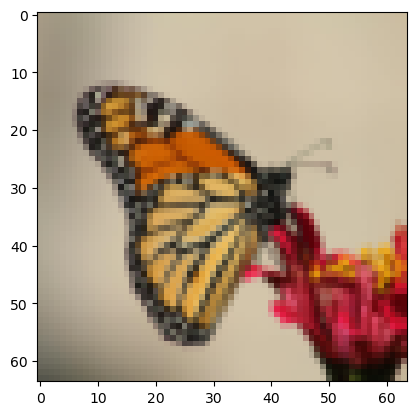

In [272]:
from torchvision.transforms import RandomHorizontalFlip, Compose, ToTensor, CenterCrop, Resize, Normalize

image_size = 64
transform = Compose([
  Resize((image_size, image_size)),
  # CenterCrop(image_size),
#   RandomHorizontalFlip(),
  ToTensor(),
#   Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

x0_image = transform(image).unsqueeze(0)
plt.imshow(x0_image[0].permute(1,2,0))

torch.Size([1, 3, 64, 64])
tensor(0.0064)
tensor([[[[0.9903]]]]) tensor([[[[0.1391]]]])


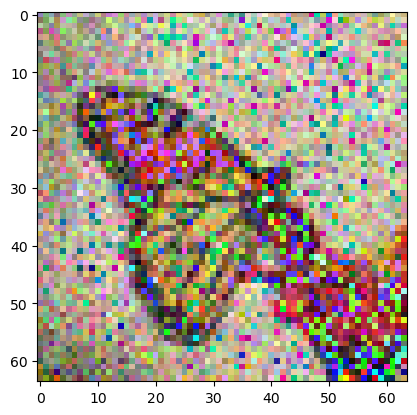

In [280]:
utils.seed_everything(1000)

x0_image = transform(image).unsqueeze(0)

def sample_by_t(tensor_to_sample, timesteps, x_shape):
    batch_size = timesteps.shape[0]
    sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
    sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
    return sampled_tensor.to(timesteps.device)

def sample_q(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x0.shape)
    print(sqrt_alphas_bar_t[-1])
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x0.shape)
    print(sqrt_alphas_bar_t_sampled, sqrt_1_minus_alphas_bar_t_sampled)
    x_t = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise
    return x_t

def get_noisy_image(x0, t, transform=Compose([ToPILImage()])):
    x_noisy = sample_q(x0, t)
    noise_image = transform(x_noisy.squeeze())
    return noise_image

noisy_image = get_noisy_image(x0_image, t)
plt.imshow(noisy_image)

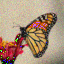

In [202]:
from torchvision.transforms import ToPILImage

reverse_transform_pil = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
  ToPILImage()
])

reverse_transform_tensor = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
])

num_timesteps = 1000
betas_t = linear_schedule(num_timesteps)

alphas_t = 1. - betas_t
alphas_bar_t = torch.cumprod(alphas_t, dim=0)
alphas_bar_t_minus_1 = torch.cat((torch.tensor([0]), alphas_bar_t[:-1]))
one_over_sqrt_alphas_t = 1. / torch.sqrt(alphas_t)
sqrt_alphas_t = torch.sqrt(alphas_t)
sqrt_alphas_bar_t = torch.sqrt(alphas_bar_t)
sqrt_alphas_bar_t_minus_1 = torch.sqrt(alphas_bar_t_minus_1)
sqrt_1_minus_alphas_bar_t = torch.sqrt(1. - alphas_bar_t)
# the variance of q(xₜ₋₁ | xₜ, x₀) as in part 3
posterior_variance = (1. - alphas_bar_t_minus_1) / (1. - alphas_bar_t) * betas_t

def sample_by_t(tensor_to_sample, timesteps, x_shape):
  batch_size = timesteps.shape[0]
  sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
  sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
  return sampled_tensor.to(timesteps.device)

def sample_q(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x0.shape)
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x0.shape)
    x_t = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise
    return x_t
     

def get_noisy_image(x0, t, transform=reverse_transform_pil):
    x_noisy = sample_q(x0, t)
    noise_image = transform(x_noisy.squeeze())
    return noise_image
     

import matplotlib.pyplot as plt
def show_noisy_images(noisy_images):
    num_of_image_sets = len(noisy_images)
    num_of_images_in_set = len(noisy_images[0])
    image_size = noisy_images[0][0].size[0]

    full_image = Image.new('RGB', (image_size * num_of_images_in_set + (num_of_images_in_set - 1), image_size * num_of_image_sets + (num_of_image_sets - 1)))
    for set_index, image_set in enumerate(noisy_images):
        for image_index, image in enumerate(image_set):
            full_image.paste(image, (image_index * image_size + image_index, set_index * image_size + set_index))

    plt.imshow(full_image)
    plt.axis('off')
    return full_image

t = torch.tensor([20])

get_noisy_image(x0, t)

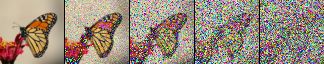

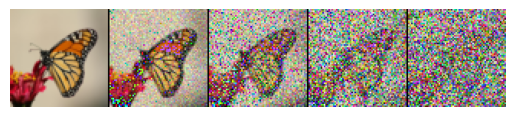

In [129]:
show_noisy_images([[get_noisy_image(x0, torch.tensor([t])) for t in [0, 50, 100, 150, 200]]])
